In [104]:
# import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# import nltk
from nltk.corpus import stopwords
%matplotlib inline

In [105]:
# read in data
calendar=pd.read_csv('data/calendar.csv')
listings=pd.read_csv('data/listings.csv')
reviews=pd.read_csv('data/reviews.csv')

**Some questions** to answer with this dataset
1. What are top 5 neighborhoods with most no of listings? 
2. What are average listing price for each neighborhood?
3. Which is the busiest season of the year and how prices changed during peak season?
4. What factors of the listing correlate best for predicting the price?

#### Data overview

Data are downloaded from https://www.kaggle.com/airbnb/seattle. 
Original data are collected by Airbnb Inside, a personally funded site which is not associated with Airbnb. Data were scraped from Airbnb websites. More about Airbnb Inside and the original data can be found here http://insideairbnb.com/about.html


Three tables are contained in this data
- calendar table includes one year's data - price and availability- scraped from the website. (Could see time trends of price over the year and availability throughout the year.) 
- listings table include desciption about the place, host information, neighborhood information, room details, prices, availaiblities, review rating scores, and some other info. 
- reviews includes guest comments for each of the listings.

Explore dataset with `df.head()`, `df.info()`, `df.describe()`

In [106]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [107]:
listings.info()
# 3818 listings, 2751 hosts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

#### Data preparation

In [108]:
listings['price'].head()

0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

As we can note that the price attribute is supposed to have numerical values but the data type is object because it stores strings with '$' signs. We need to convert this column into numerical data type.m

In [110]:
"""
    Converts price in the string format like "$1,125.00" into numeric value 1125.00
    INPUT:
    - string price in string format
    OUTPUT:
    - float value corresponding to the price or None if the input is not parseable to float
"""
def str_to_num (string):
    if string is not None:
        if type(string) is str and string.startswith('$'):
            return float(string.replace('$', '').replace(',', ''))
        else:
            return None
    else:
        return None

In [143]:
# clean up price column in listings. remove "$" and "," and convert to numerical values
listings = pd.concat([listings.drop('price', axis=1), listings["price"].apply(str_to_num)], axis=1)
listings['price'].head()

0     85.0
1    150.0
2    975.0
3    100.0
4    450.0
Name: price, dtype: float64

In [112]:
# clean up price column in calendar. remove "$" and "," and convert to numerical values
calendar = pd.concat([calendar.drop('price', axis=1), calendar["price"].apply(str_to_num)], axis=1)
calendar['price'].head()

0    85.0
1    85.0
2     NaN
3     NaN
4     NaN
Name: price, dtype: float64

In [116]:
calendar['date'].dtypes

dtype('O')

In [120]:
# for caldenar, change data type for date
calendar["date"] = pd.to_datetime(calendar["date"], format="%Y-%m-%d")
calendar["date"].head()

0   2016-01-04
1   2016-01-05
2   2016-01-06
3   2016-01-07
4   2016-01-08
Name: date, dtype: datetime64[ns]

In [123]:
# change data type for reviews
reviews["date"] = pd.to_datetime(reviews["date"], format="%Y-%m-%d")
reviews["date"].head()

0   2015-07-19
1   2015-07-20
2   2015-07-26
3   2015-08-02
4   2015-08-10
Name: date, dtype: datetime64[ns]

In [91]:
calendar['available']  = calendar['available'] == 't'
calendar['available'].head

<bound method NDFrame.head of 0           True
1           True
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9           True
10          True
11         False
12         False
13         False
14          True
15          True
16          True
17         False
18         False
19         False
20          True
21          True
22          True
23          True
24          True
25         False
26         False
27         False
28          True
29          True
           ...  
1393540    False
1393541    False
1393542    False
1393543    False
1393544    False
1393545    False
1393546    False
1393547    False
1393548    False
1393549    False
1393550    False
1393551    False
1393552    False
1393553    False
1393554    False
1393555    False
1393556    False
1393557    False
1393558    False
1393559    False
1393560    False
1393561    False
1393562    False
1393563    False
1393564    False
1393565    False
1

In [124]:
# checking the type of amenities available in listing dataset considering only first row
list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), listings.amenities.iloc[0].split(",")))

['TV',
 'Cable TV',
 'Internet',
 'Wireless Internet',
 'Air Conditioning',
 'Kitchen',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer']

In [125]:
"""
    Separates the string value of `amenities` attribute in the row, into a list of individual amenities.
    
    INPUT:
    - row : from dataset having amenities attribute
    OUTPUT:    
    - list of amenities derived from the value of `amenities` attribute in row
"""
def separate_amenities(row):
    amenities = row.amenities
    list_to_return = []
    if (amenities is not None and type(amenities) == str):            
        list_to_return = list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), amenities.split(",")))
    if '' in list_to_return:
        list_to_return.remove('')
    return list_to_return
listings["amenities_list"] = listings.apply(separate_amenities, axis=1)

In [127]:
possible_amenities = listings['amenities_list'].apply(pd.Series).stack().unique()
possible_amenities

array(['TV', 'Cable TV', 'Internet', 'Wireless Internet',
       'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly',
       'Washer', 'Dryer', 'Free Parking on Premises',
       'Buzzer/Wireless Intercom', 'Smoke Detector',
       'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card',
       'Fire Extinguisher', 'Essentials', 'Pets Allowed',
       'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub',
       'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in',
       'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace',
       'Suitable for Events', 'Elevator in Building',
       'Lock on Bedroom Door', 'Wheelchair Accessible', 'Gym', 'Pool',
       'Smoking Allowed', 'Other pet(s)', 'Doorman', 'Washer / Dryer'],
      dtype=object)

In [128]:
"""
    Assigns new boolean attribute to the row based on the presence of that amenity in the list.
    Returns updated row with additional attributes corresponding to the amenities added to it.
    
    INPUT:
    - row containing attributes related to the property, including `amenities_list`
    OUTPUT:
    - row containing newly added boolean attributes indicating the presence of each possible type of amenity in the property
"""
def add_amenities_columns (row):
    amenities = set(row.amenities_list)
    for possible_amenity in possible_amenities:
        row["amenity_" + possible_amenity] = possible_amenity in amenities
    return row

listings = listings.apply(add_amenities_columns, axis=1)

In [130]:
listings["instant_bookable"] = listings["instant_bookable"] == "t"
listings["instant_bookable"].head()

C:\Users\Prakash.Goswami\anc\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0    False
1    False
2    False
3    False
4    False
Name: instant_bookable, dtype: bool

#### Evaluation

#### Question 1. What are top 5 neighborhoods with most no of listings?

In [10]:
# difference between neighborhood and neighbourhood_group_cleansed? choose one of the fields as location group
#listings['neighbourhood'].unique()
#listings.loc[listings['neighbourhood_group_cleansed']=='Cascade', 'neighbourhood'].unique()
#listings.loc[listings['neighbourhood']=='Eastlake', 'neighbourhood_group_cleansed'].unique()

Text(0, 0.5, '# Listings')

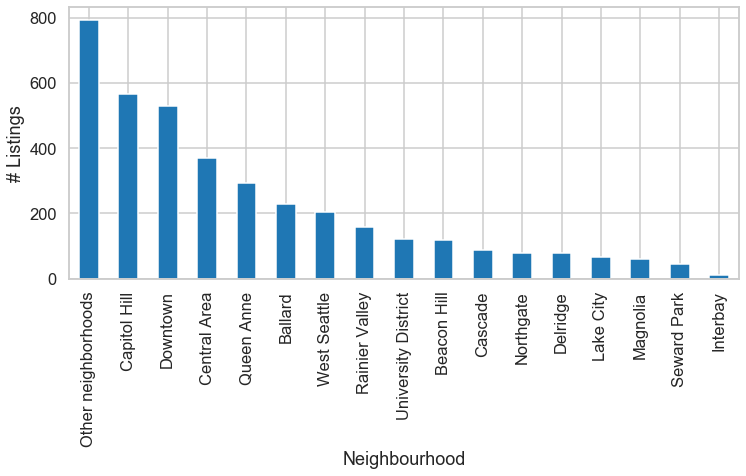

In [138]:
# number of lists by location
sns.set_context('talk')
#sns.reset_orig()
count_stats=listings.groupby(['neighbourhood_group_cleansed'], as_index=False)['id'].count()
count_stats.sort_values(by='id', ascending=False, inplace=True)
# store sorted neighborhood in 'neighborhood_sorted', this will be used in remaining analysis where neighborhood is x
neighborhood_sorted = count_stats['neighbourhood_group_cleansed'].unique()
count_stats.plot.bar(x='neighbourhood_group_cleansed', y='id', figsize=(12,5), legend=False)
plt.gca().set_xlabel("Neighbourhood")
plt.gca().set_ylabel("# Listings")

In [139]:
# guests comments by neighborhood
#reviews = reviews.merge(listings[['id', 'neighbourhood_group_cleansed']], left_on='listing_id', right_on='id',how='inner')
#count_stats=reviews.groupby(['neighbourhood_group_cleansed'], as_index=False)['reviewer_id'].count()
#count_stats.sort_values(by='reviewer_id', ascending=False, inplace=True)
#count_stats.plot.bar(x='neighbourhood_group_cleansed', y='reviewer_id', figsize=(12,5), legend=False)
#plt.gca().set_xlabel("Neighbourhood")
#plt.gca().set_ylabel("# Reviews")

Text(0.5, 0, 'No of Listings')

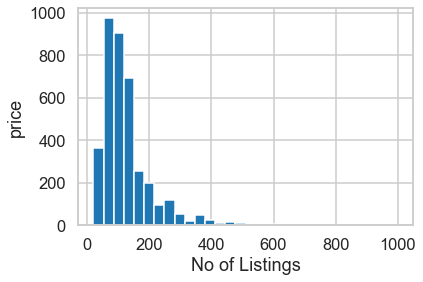

In [147]:
# histogram of listing prices
# listings["price"].plot.hist(bins=30)
# listings['price'].head()
listings['price'].head()
listings['price'].plot.hist(bins=30)
plt.ylabel('price')
plt.xlabel('No of Listings')

In [69]:
# describe listing prices
listings['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

#### Question 2. What are average listing price for each neighborhood?

In [16]:
# price by location, stats table
# price_by_area=listings.groupby(['neighbourhood_group_cleansed'],as_index=False)['price'].agg([np.mean, 'sem', 'count', 'max', 'min', 'median']).reset_index()
# price_by_area.sort_values(by='mean', ascending=False)

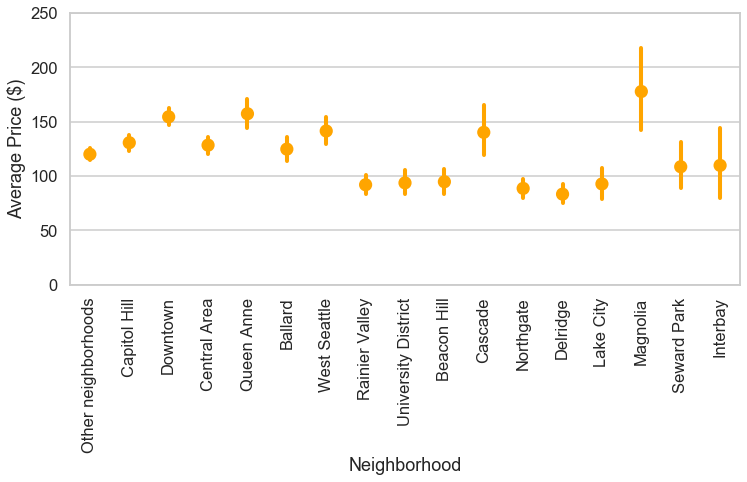

In [70]:
# matplotlib
#plt.errorbar(x=price_by_area.index.tolist(), y=price_by_area['mean'], yerr=price_by_area['sem']*2,fmt='o')
#plt.xticks(price_by_area.index.tolist())
#plt.gca().set_xticklabels(price_by_area['neighbourhood_group_cleansed'],rotation=90);
plt.figure(figsize=(12,5))
# sort neighbors to match pandas plots
#sorted_neighbors = sorted(listings['neighbourhood_group_cleansed'].unique().tolist())
ax = sns.pointplot(x='neighbourhood_group_cleansed',y='price', data=listings, join=False, order = neighborhood_sorted, color='orange')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Average Price ($)')
ax.set_ylim(0, 250);

In [18]:
#listings.loc[listings.neighbourhood_group_cleansed=='Magnolia', 'bedrooms'].describe()
#listings.loc[listings.neighbourhood_group_cleansed=='Downtown', 'bedrooms'].describe()

In [19]:
# normalize price by bedrooms
listings.loc[listings['bedrooms']==0, 'bedrooms']=0.7
listings['price_per_bed']=listings['price']/(listings['bedrooms'])

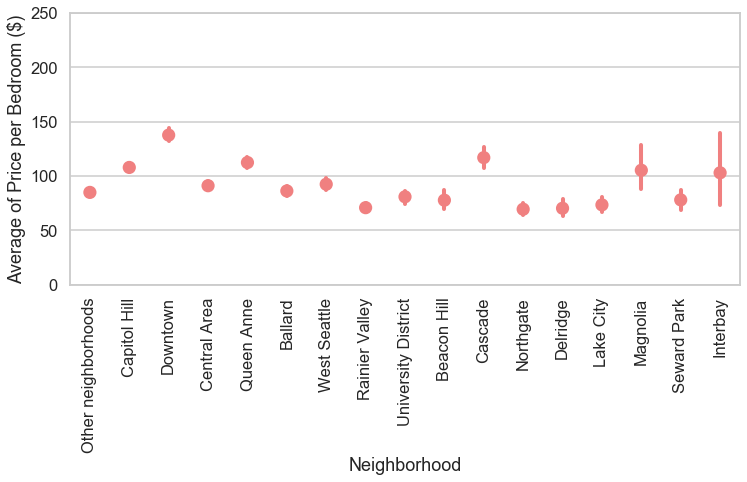

In [72]:
plt.figure(figsize=(12,5))
# sort neighbors to match pandas plots
#sorted_neighbors = sorted(listings['neighbourhood_group_cleansed'].unique().tolist())
ax = sns.pointplot(x='neighbourhood_group_cleansed',y='price_per_bed', data=listings, join=False, order=neighborhood_sorted, color='lightcoral')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Average of Price per Bedroom ($)')
ax.set_ylim(0, 250);

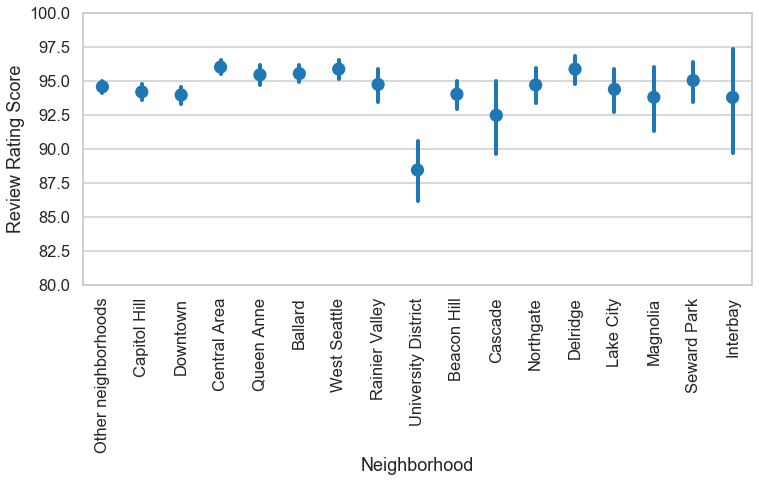

In [45]:
plt.figure(figsize=(12,5))
# sort neighbors to match pandas plots
#sorted_neighbors = sorted(listings['neighbourhood_group_cleansed'].unique().tolist())
ax = sns.pointplot(x='neighbourhood_group_cleansed',y='review_scores_rating', data=listings, join=False, order=neighborhood_sorted)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Review Rating Score')
ax.set_ylim(80, 100);

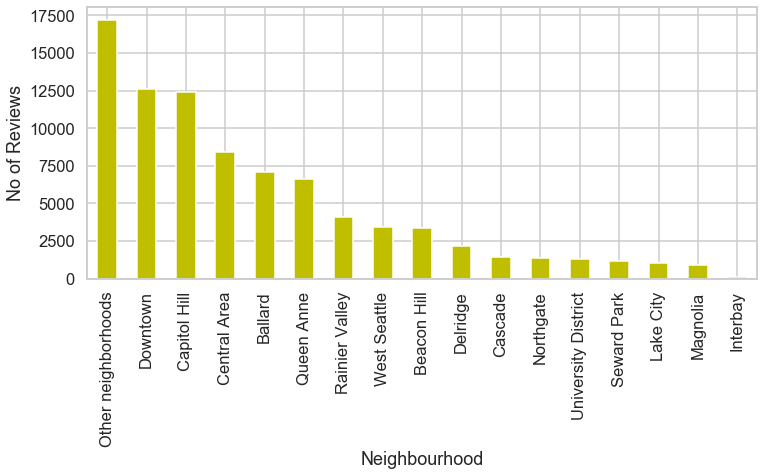

In [79]:
count_reviews=listings.groupby(['neighbourhood_group_cleansed'], as_index=False)['number_of_reviews'].sum()
count_reviews.sort_values(by='number_of_reviews', ascending=False, inplace=True)
count_reviews.plot.bar(x='neighbourhood_group_cleansed', y='number_of_reviews', figsize=(12,5), legend=False, color='y')
plt.gca().set_xlabel("Neighbourhood")
plt.gca().set_ylabel("No of Reviews");

In [24]:
# percent super host by location
#listings['host_is_superhost']=listings['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
#pct_super_by_area=listings.groupby(['neighbourhood_group_cleansed'],as_index=False)['host_is_superhost'].mean()
#pct_super_by_area.sort_values(by='host_is_superhost', ascending=False)

#### Question #2, neighborhood vibe using listing descriptions?

In [25]:
# need to download nltk if not used before otherwise will pop up TK errors
#nltk.download()

In [26]:
def top_30_freq_words(neigh):
    '''
    Find and print top 30 most frequent words from all postings describing the neighbourhood
    
    Argument
    neigh: string, name of the neighbourhood
    
    function prints out neighbourhood name and its top 30 most frequently used words
    
    '''
    tokens_all = []
    descriptions = listings.loc[listings['neighbourhood_group_cleansed']==neigh, 'description'].tolist()
    for desc in descriptions:
        tokens = nltk.word_tokenize(desc)
        tokens = [x for x in tokens if x not in stopwords_to_remove]
        tokens = [x for x in tokens if x not in others_to_remove]
        tokens_all = tokens_all + tokens
    fdist = FreqDist(tokens_all).most_common(30)
    print(neigh + ': ')
    print(fdist)

#### Question 3. Which is the busiest season of the year and how prices changed during peak season?

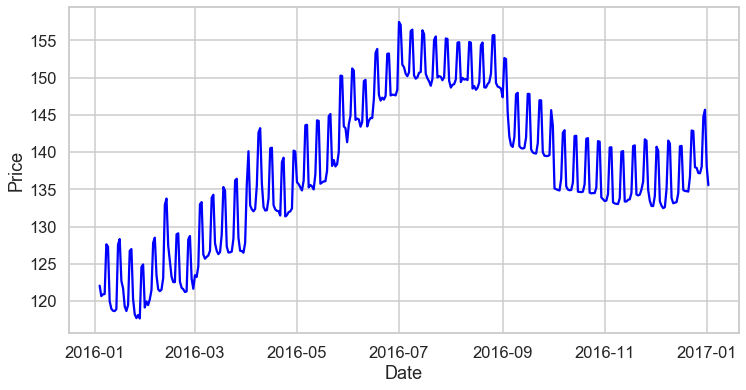

In [148]:

avgByDate=calendar.groupby(['date'], as_index=False)['price'].mean()
plt.figure(figsize=(12,6))
sns.lineplot(data=avgByDate, x='date', y='price',color="b")
plt.gca().set_xlabel("Date")
plt.gca().set_ylabel("Price");
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [131]:

df = pd.merge(listings_cleaned, calendar, left_on="id", right_on="listing_id", how="inner", suffixes=("_listings", "_calendar"))

In [87]:
# fact= calendar.dropna(subset=["price_calendar"])
calendar.head(2)
# listings.head(2)
# reviews.head(2)



,listing_id,date,available,price,id_x,neighbourhood_group_cleansed_x,id_y,neighbourhood_group_cleansed_y,id,neighbourhood_group_cleansed
0,241032,2016-01-04,t,85.0,241032,Queen Anne,241032,Queen Anne,241032,Queen Anne
1,241032,2016-01-05,t,85.0,241032,Queen Anne,241032,Queen Anne,241032,Queen Anne


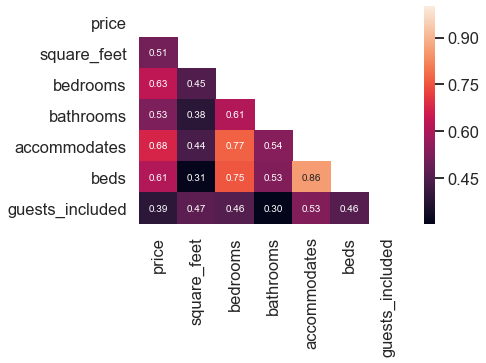

In [136]:
matrix = np.triu(df[["price_calendar",                                
                "square_feet",
                "bedrooms", 
                "bathrooms", 
                "accommodates",
                "beds", 
                "guests_included"
                ]].rename(columns={"price_calendar": "price"}).corr())
sns.heatmap(df[["price_calendar",                                
                "square_feet",
                "bedrooms", 
                "bathrooms", 
                "accommodates",
                "beds", 
                "guests_included"
                ]].rename(columns={"price_calendar": "price"}).corr(), annot=True, fmt=".2f",mask=matrix);
